<a href="https://colab.research.google.com/github/Untick/IrisID_gr2/blob/Sergei-Riuntiu-folder/IrisID_with_image_generator_and_new_dataset_06_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт Библиотек

In [143]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D, Lambda, SpatialDropout2D
from keras.layers import Resizing
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras import utils
from sklearn.model_selection import train_test_split
from google.colab import drive
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np 
import random
import gc 
import shutil
import zipfile

from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import LambdaCallback

from scipy.ndimage import gaussian_laplace
from skimage.filters import gabor
from skimage.color import rgb2gray

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Загрузка и подготовка данных

In [6]:
path_dir_zip = '/content/drive/MyDrive/IrisID/iris_db/zip'
path_extract = '/content/drive/MyDrive/IrisID/iris_db/unzip'
path_train = '/content/drive/MyDrive/IrisID/iris_db/Train'
path_test = '/content/drive/MyDrive/IrisID/iris_db/Test'

In [7]:



def unzip(zip_file_path, extract_to):
    if os.path.exists(extract_to):
        shutil.rmtree(extract_to)
    os.makedirs(extract_to)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)


def create_dir(path_dir):
    try:
        if os.path.exists(path_dir):
            shutil.rmtree(path_dir)
        os.makedirs(path_dir)
    except OSError as e:
        print(f"Ошибка при создании директории {path_dir}: {e}")


def del_dir(path_dir):
    try:
        os.rmdir(path_dir)
    except OSError as e:
        print(f"Ошибка при удалении папки {path_dir}: {e}")

def move_file(file_path, move_to):
    try:
        if not os.path.exists(move_to):
            os.makedirs(move_to)

        file_name = os.path.basename(file_path)
        new_path = os.path.join(move_to,file_name)

        shutil.move(file_path, new_path)
    except Exception as e:
        print(f'Ошибка при перемещении файла: {e}')

def Check_files(path_folder):
    folders_path = os.listdir(path_folder)
    for folder in folders_path:
        path_fife = os.path.join(path_folder, folder)
        files = os.listdir(path_fife)
        for file in files:
            file_name = str(file).split('_')[0]
            if file_name != str(folder):
                print(f'Файл {file_name} не принадлежит классу в папке {str(folder)}')
                
def plot_result(train_acc, val_acc, train_loss, val_loss):
  
  plt.figure(figsize=(16, 10))
  
  plt.subplot(2, 2, 1)
  plt.title('Точность', fontweight='bold')
  plt.plot(train_acc, label='Точность на обучащей выборке')
  plt.plot(val_acc, label='Точность на проверочной выборке')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()

  plt.subplot(2, 2, 2)
  plt.title('Ошибка', fontweight='bold')
  plt.plot(train_loss, label='Ошибка на обучающей выборке')
  plt.plot(val_loss, label='Ошибка на проверочной выборке')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Ошибка')
  plt.legend()

  plt.show()

In [ ]:
# Создание директорий
create_dir(path_train)
create_dir(path_test)
create_dir(path_extract)

In [ ]:
# Извелечение и распределение файлов
files_zip = os.listdir(path_dir_zip)
for file_zip in files_zip:
    path_file_zip = os.path.join(path_dir_zip, file_zip)
    extract_to = os.path.join(path_extract, file_zip[:-4])
    unzip(path_file_zip, extract_to)

folders_unzip_dir = os.listdir(path_extract)
for folder_unzip in folders_unzip_dir:
    path_folder_unzip = os.path.join(path_extract, folder_unzip)
    img_files = os.listdir(path_folder_unzip)
    for img_file in img_files:
        file_path = os.path.join(path_folder_unzip, img_file)
        folder = os.path.splitext(img_file)[0][:-2]
        move_to = os.path.join(path_train, folder)
        move_file(file_path, move_to)
    # del_dir(path_folder_unzip)

folders_train = os.listdir(path_train)
for folder_train in folders_train:
    path_img_train = os.path.join(path_train, folder_train)
    img_files_train = os.listdir(path_img_train)
    img_files_train.sort()
    for img_file_train in img_files_train:
        file_path = os.path.join(path_img_train, img_file_train)
        folder = os.path.splitext(img_file_train)[0][:-2]
        move_to = os.path.join(path_test, folder)
        move_file(file_path, move_to)
        break

# del_dir(path_extract)
# Check_files(path_test)
# Check_files(path_train)
  

In [8]:
Check_files(path_test)
Check_files(path_train)

In [ ]:
del_dir(path_extract)

Ошибка при удалении папки /content/drive/MyDrive/IrisID/iris_db/unzip: [Errno 39] Directory not empty: '/content/drive/MyDrive/IrisID/iris_db/unzip'


# Удаление артефактов от ламп

In [14]:
# проверяем содержимое папки

IMAGE_TRAIN_PATH = '/content/drive/MyDrive/IrisID/iris_db/Train' # изображения тренировочной выборки
IMAGE_TEST_PATH = '/content/drive/MyDrive/IrisID/iris_db/Test' # изображения тестовой выборки

IMAGE_FILES_TRAIN = sorted(os.listdir(IMAGE_TRAIN_PATH))
IMAGE_FILES_TEST = sorted(os.listdir(IMAGE_TEST_PATH))

print(IMAGE_FILES_TRAIN[:5])
print(IMAGE_FILES_TEST[:5])

['001L', '001R', '002L', '002R', '003L']
['001L', '001R', '002L', '002R', '003L']


## Удаление внешней границы радужки

In [160]:
# создаем функцию обрезки изображения
import cv2

def crop_circular_image(image_path):
    # Загрузка изображения
    image = cv2.imread(image_path)

    # Конвертация из BGR в RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Получение размеров изображения
    height, width, _ = image.shape

    # Создание круглой маски
    mask = np.zeros((height, width), np.uint8)
    center = (width // 2, height // 2)
    radius = int(min(width, height) // 2.025)
    cv2.circle(mask, center, radius, (255, 255, 255), -1)

    # Применение маски к изображению
    circular_image = cv2.bitwise_and(image, image, mask=mask)

    # Вычисление координат верхнего левого угла прямоугольника
    x = int((width - min(width, height)) // 2.1)
    y = int((height - min(width, height)) // 2)

    # Вырезание прямоугольной области из изображения
    cropped_image = circular_image[y:y + min(width, height), x:x + min(width, height)]

    return cropped_image

/content/drive/MyDrive/IrisID/iris_db/Train/046L/046L_3.png


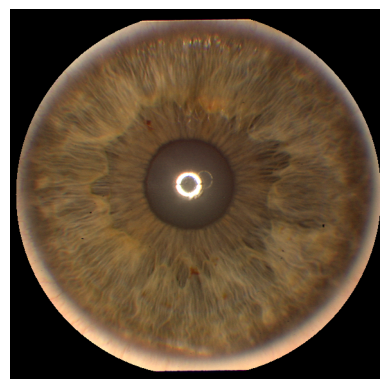

In [161]:
print(img_path + img_title)
cropped_pupil = crop_circular_image(img_path + img_title
                           )
plt.imshow(cropped_pupil)
plt.axis('off')
plt.show()

## Удаление зрачка

In [92]:
def crop_pupil_center(image_path):
    # Загрузка изображения
    image = cv2.imread(image_path)

    # Конвертация из BGR в RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Получение размеров изображения
    height, width, _ = image.shape

    # Создание круглой маски для зрачка
    mask = np.zeros((height, width), np.uint8)
    center = (width // 2, height // 2)
    radius = int(min(width, height) // 6)
    cv2.circle(mask, center, radius, (255, 255, 255), -1)

    # Применение инвертированной маски к изображению для удаления зрачка
    inverted_mask = cv2.bitwise_not(mask)
    cropped_image = cv2.bitwise_and(image, image, mask=inverted_mask)

    return cropped_image

/content/drive/MyDrive/IrisID/iris_db/Train/055L/055L_2.png


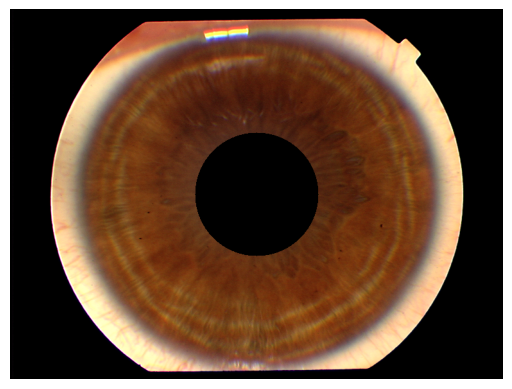

In [93]:
print(img_path + img_title)
cropped_pupil = crop_eye(img_path + img_title
                           )
plt.imshow(cropped_pupil)
plt.axis('off')
plt.show()

## Удаление внешней части и зрачка 

In [99]:
def crop_eye(image_path):
    # Загрузка изображения
    image = cv2.imread(image_path)

    # Конвертация из BGR в RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Получение размеров изображения
    height, width, _ = image.shape

    # Создание круглой маски для внешнего контура радужки
    mask = np.zeros((height, width), np.uint8)
    center = (width // 2, height // 2)
    radius = int(min(width, height) // 2.025)
    cv2.circle(mask, center, radius, (255, 255, 255), -1)

    # Применение маски к изображению
    circular_image = cv2.bitwise_and(image, image, mask=mask)

    # Создание маски для зрачка
    pupil_mask = np.zeros((height, width), np.uint8)
    pupil_center = (width // 2, height // 2)
    pupil_radius = int(min(width, height) // 8)
    cv2.circle(pupil_mask, pupil_center, pupil_radius, (255, 255, 255), -1)

    # Применение инвертированной маски зрачка к изображению для удаления зрачка
    inverted_pupil_mask = cv2.bitwise_not(pupil_mask)
    cropped_image = cv2.bitwise_and(circular_image, circular_image, mask=inverted_pupil_mask)

    return cropped_image

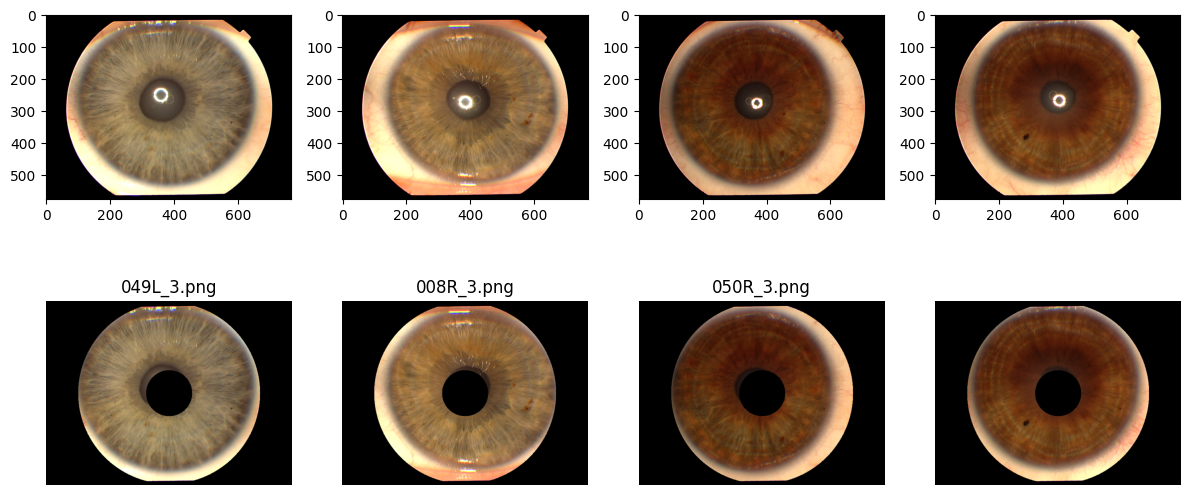

In [152]:
# print(img_path + img_title)
# cropped_pupil = center_eye(img_path + img_title)
# fig = plt.figure(figsize=(10,5))
# plt.imshow(cropped_pupil)
# plt.axis('off')
# plt.show()

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
img_title = ''

for i in range(4):
    dirs_path = f'{IMAGE_TRAIN_PATH}/'
    img_path = dirs_path + random.choice(IMAGE_FILES_TRAIN) + '/'
    img_title = random.choice(os.listdir(img_path))
    # ax = fig.add_subplot(2, 4, i + 1)
    ax.set_title(img_title)
    ax = axes[0, i]
    ax.imshow(Image.open(img_path + img_title)) # применяем функцию обрезки изображения
    ax = axes[1, i]
    ax.imshow(crop_eye(img_path + img_title)) # применяем функцию обрезки изображения
    ax.axis('off')
# Отображение графика
plt.tight_layout()
plt.show()

## Попытка сдвига зрачка по центру - безуспешно

In [154]:
 # Попытка сдвига по центру - не удалось
def center_eye(image_path):
    # Загрузка изображения
    image = cv2.imread(image_path)

    # Конвертация из BGR в RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Получение размеров изображения
    height, width, _ = image.shape

    # Создание круглой маски для внешнего контура радужки
    mask = np.zeros((height, width), np.uint8)
    center = (width // 2, height // 2)
    radius = int(min(width, height) // 2.025)
    cv2.circle(mask, center, radius, (255, 255, 255), -1)

    # Применение маски к изображению
    circular_image = cv2.bitwise_and(image, image, mask=mask)

    # Преобразование изображения в оттенки серого
    gray_image = cv2.cvtColor(circular_image, cv2.COLOR_RGB2GRAY)

    # Бинаризация изображения с помощью порогового значения
    _, binary_image = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)

    # Поиск контуров на бинарном изображении
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Поиск контура зрачка
    pupil_contour = max(contours, key=cv2.contourArea)

    # Вычисление координат ограничивающего прямоугольника зрачка
    x, y, w, h = cv2.boundingRect(pupil_contour)

    # Вычисление центра зрачка
    pupil_center = (int(x + w/2), int(y + h/2))

    # Отметка центра зрачка на изображении красным крестом
    cv2.drawMarker(image, pupil_center, color=(255, 0, 0), markerType=cv2.MARKER_CROSS,
                   markerSize=10, thickness=2)

    # Вычисление сдвига для центрирования по центру зрачка
    shift_x = int(width // 2 - pupil_center[0])
    shift_y = int(height // 2 - pupil_center[1])

    # Сдвиг изображения радужки и зрачка
    centered_image = np.roll(circular_image, shift_x, axis=1)
    centered_image = np.roll(centered_image, shift_y, axis=0)

    # Вычисление координат верхнего левого угла прямоугольника
    x = int((width - min(width, height)) // 2.1)
    y = int((height - min(width, height)) // 2)

    # Вырезание прямоугольной области из изображения
    cropped_image = centered_image[y:y + min(width, height), x:x + min(width, height)]

    return cropped_image, pupil_center, radius

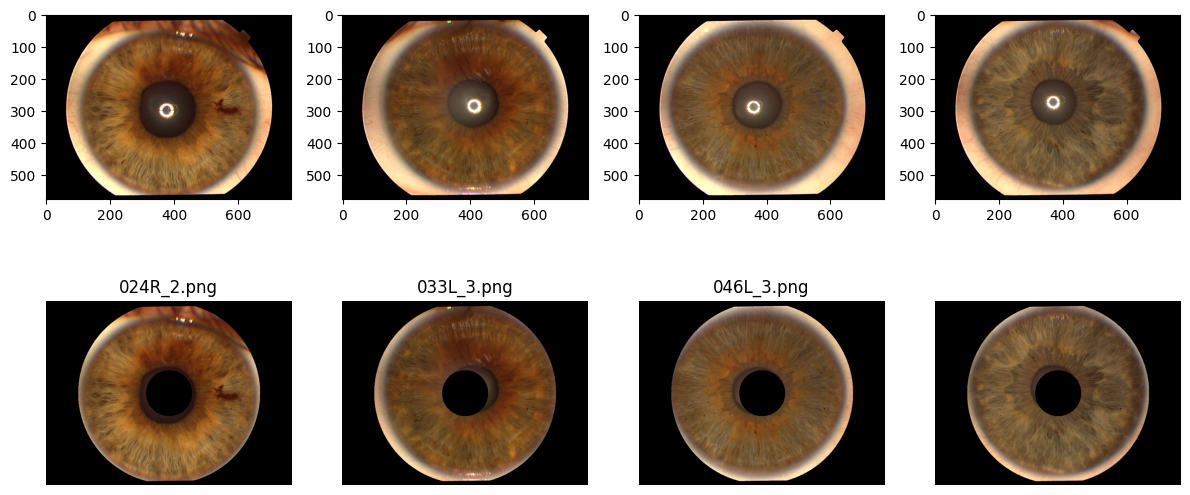

In [158]:
# выводим серию случайных обрезанных изображений на экран

# fig = plt.figure(figsize=(10,5))
# Создание сетки подграфиков
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

for i in range(4):
    dirs_path = f'{IMAGE_TRAIN_PATH}/'
    img_path = dirs_path + random.choice(IMAGE_FILES_TRAIN) + '/'
    img_title = random.choice(os.listdir(img_path))
    # ax = fig.add_subplot(2, 4, i + 1)
    ax.set_title(img_title)
    ax = axes[0, i]
    ax.imshow(Image.open(img_path + img_title)) # применяем функцию обрезки изображения
    ax = axes[1, i]
    ax.imshow(crop_eye(img_path + img_title)) # применяем функцию обрезки изображения
    ax.axis('off')
# Отображение графика
plt.tight_layout()
plt.show()

# Создание обработанной базы 

In [166]:
path_train_ext = '/content/drive/MyDrive/IrisID/iris_db_ext/Train'

In [183]:
# Формирование массивов x_train и y_train
x_train = []
y_train = []
num_class = 0
for cls in Classes:
    path_classes = os.path.join(path_train, cls)
    images = os.listdir(path_classes)
    for img in images:
        path_images = os.path.join(path_classes, img)        
        cropped_image = crop_eye(path_images)
               
        # Сохранение обработанного изображения в файл
        cv2.imwrite(path_train_ext, cropped_image)
        # cropped_image.save(path_train_ext)

error: ignored

# Перевод в полярные координаты

In [174]:
# создаем функцию обрезки изображения

def crop_circular_image2(image_path):
    # Загрузка изображения
    image = cv2.imread(image_path)

    # Конвертация из BGR в RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Получение размеров изображения
    height, width, _ = image.shape

    # Создание круглой маски
    mask = np.zeros((height, width), np.uint8)
    center = (width // 2, height // 2)
    radius = int(min(width, height) // 2.025)
    cv2.circle(mask, center, radius, (255, 255, 255), -1)

    # Применение маски к изображению
    circular_image = cv2.bitwise_and(image, image, mask=mask)

    # Вычисление координат верхнего левого угла прямоугольника
    x = int((width - min(width, height)) // 2.1)
    y = int((height - min(width, height)) // 2)

    # Вырезание прямоугольной области из изображения
    cropped_image = circular_image[y:y + min(width, height), x:x + min(width, height)]

    # Получение размеров обрезанного изображения
    cropped_height, cropped_width, _ = cropped_image.shape

    # Переопределение центра и радиуса для обрезанного изображения
    center = (cropped_width // 2, cropped_height // 2)
    radius = min(cropped_width, cropped_height) // 2

    return cropped_image, center, radius

In [138]:
# создаем функцию полярного преобразования координат

def unwrap_image(cropped_image, center, radius):
    # создаем новое изображения для результатов развертывания
    unwrapped_image = np.zeros((radius, 360, 3), dtype=np.uint8)

    # пройдем по всем пикселям в новом изображении и копируйте их из обрезанного изображения
    for r in range(radius):
        for theta in range(360):
            # преобразуем полярные координаты в декартовы
            x_unwrap = center[0] + r * np.cos(np.deg2rad(theta))
            y_unwrap = center[1] + r * np.sin(np.deg2rad(theta))

            # копируем пиксель
            unwrapped_image[r, theta] = cropped_image[int(y_unwrap), int(x_unwrap)]
            
    # обрезание изображения для получения прямоугольника в центре
    rectangle_height = int(radius // 2.5) #  сохраняем центральную треть изображения
    rectangle_start = int((radius - rectangle_height) // 2) # начало прямоугольника
    rectangle_image = unwrapped_image[rectangle_start : rectangle_start + rectangle_height, :]

    return rectangle_image

In [179]:
# создаем фильтр Гаусса и оператор Лапласа
def apply_gaussian_laplace(image, sigma=1.2):
    # Применение фильтра Гаусса и оператора Лапласа
    filtered_image = gaussian_laplace(image, sigma)

    return filtered_image

# создаем функцию для извлечения признаков с использованием вейвлетов Габора
def apply_gabor_filter(image, frequency=0.7):
    # преобразование изображения в оттенки серого, если оно цветное
    if len(image.shape) > 2:
        image = rgb2gray(image)

    # применение фильтра Габора
    gabor_response, _ = gabor(image, frequency)

    # нормализация gabor_response в диапазон [0, 1]
    gabor_response = (gabor_response - gabor_response.min()) / (gabor_response.max() - gabor_response.min())

    # преобразование gabor_response в тип uint8
    gabor_response = (gabor_response * 255).astype(np.uint8)

    # адаптивная бинаризация изображения
    binary_gabor = cv2.adaptiveThreshold(gabor_response, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    
    return binary_gabor

In [175]:
# cоздаем функцию, применяющую все фильтры к изображению

def process_images(img_path, img_title):
    result = []
  
    # применяем функцию обрезки изображения
    cropped_image, center, radius = crop_circular_image2(img_path)

    # "Разворачивание" обрезанного изображения
    unwrapped_image = unwrap_image(cropped_image, center, radius)

    # Применение фильтра Гаусса и оператора Лапласа
    gauss_laplace_img = apply_gaussian_laplace(unwrapped_image)

    # Извлечение признаков с использованием вейвлетов Габора
    gabor_img = apply_gabor_filter(gauss_laplace_img)

    # Получаем метку (label) из имени файла
    label = img_title

    # Сохранение результата
    result.append({
        "file_name": img_file,
        "gabor_filter": gabor_img,
        "label": label
    })
        
    return result

In [141]:
def print_dictionary_structure(processed_images):
    # Печатаем количество элементов в списке
    print(f'Количество изображений: {len(processed_images)}')
    # Собираем все метки в список
    labels = [image['label'] for image in processed_images]
    # Выводим количество уникальных меток
    print(f'Количество меток: {len(labels)}')
    
    if processed_images:
        # Получаем первый элемент
        first_image = processed_images[0]

        # Печатаем все ключи и их типы данных
        for key, value in first_image.items():
            print(f'{key}: {type(value)}')

        # Если значение - массив numpy, выводим его форму
        if isinstance(first_image['gabor_filter'], np.ndarray):
            print('Размер изображений:', first_image['gabor_filter'].shape)
    else:
        print("List 'processed_images' is empty.")

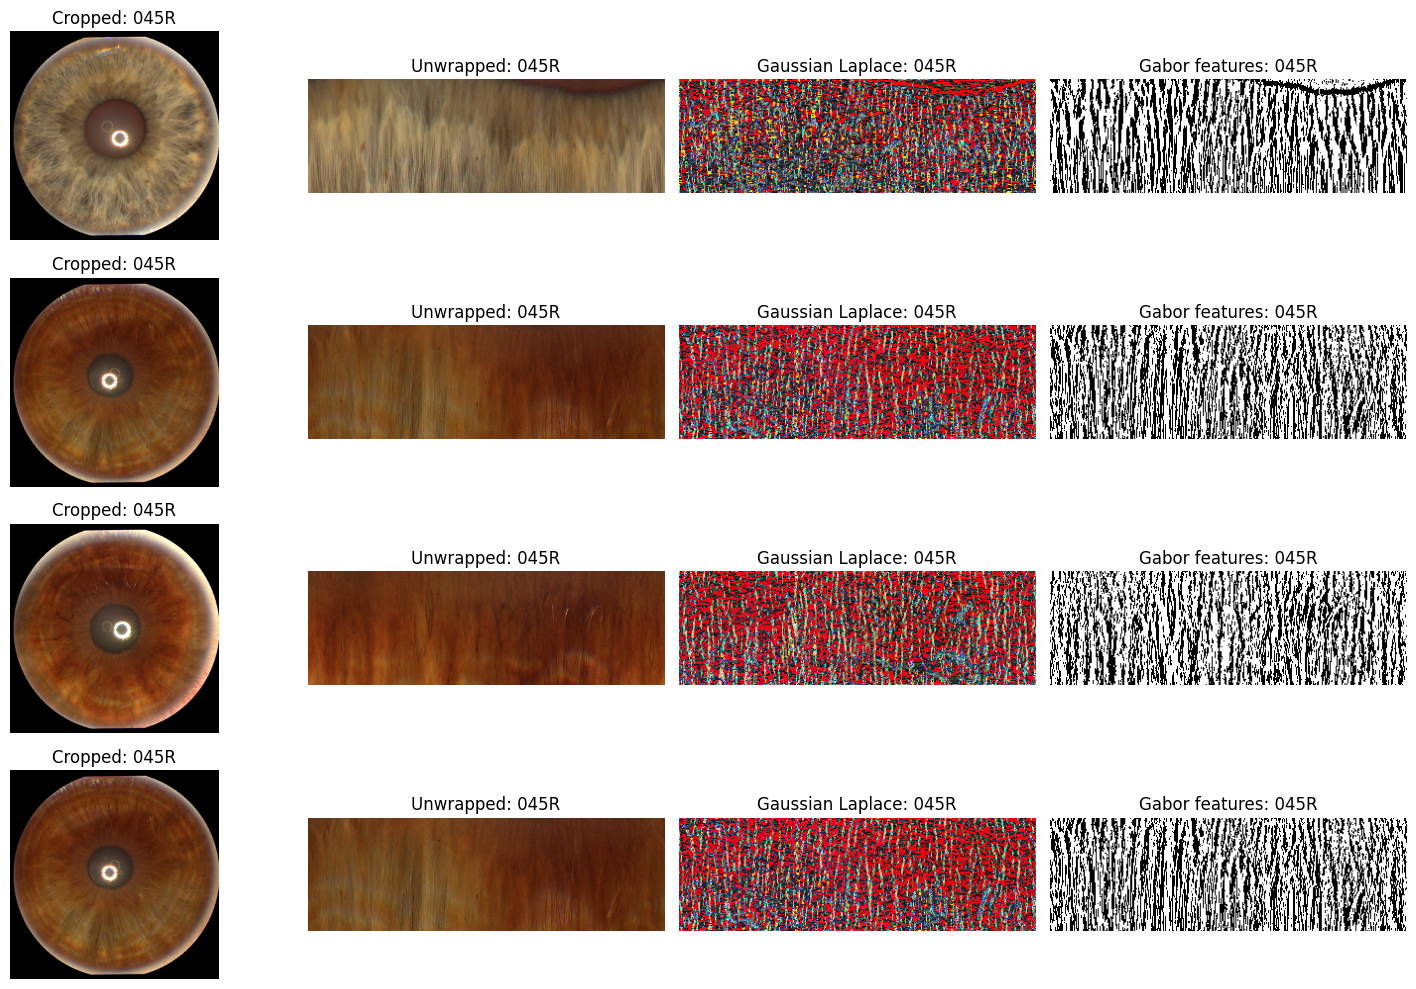

In [180]:
# выводим результаты применения фильтров

fig, axs = plt.subplots(4, 4, figsize=(15, 10)) # создаем 8 строк по 4 столбца

for i in range(4):
    dirs_path = f'{IMAGE_TRAIN_PATH}/'
    img_path = dirs_path + random.choice(IMAGE_FILES_TRAIN) + '/'
    img_title = random.choice(os.listdir(img_path))

    # Получение обрезанного изображения, центра и радиуса
    cropped_image, center, radius = crop_circular_image2(img_path + img_title)

    # "Разворачивание" обрезанного изображения
    unwrapped_image = unwrap_image(cropped_image, center, radius)

    # Применение фильтра Гаусса и оператора Лапласа
    gaussian_laplace_image = apply_gaussian_laplace(unwrapped_image)

    # Извлечение признаков с использованием вейвлетов Габора
    gabor_features = apply_gabor_filter(unwrapped_image)

    # выводим обрезанное изображение
    axs[i, 0].imshow(cropped_image)
    axs[i, 0].set_title('Cropped: ' + img_file)
    axs[i, 0].axis('off')

    # выводим развернутое изображение
    axs[i, 1].imshow(unwrapped_image)
    axs[i, 1].set_title('Unwrapped: ' + img_file)
    axs[i, 1].axis('off')

    # выводим изображение после применения фильтра Гаусса и оператора Лапласа
    axs[i, 2].imshow(gaussian_laplace_image, cmap='gray') 
    axs[i, 2].set_title('Gaussian Laplace: ' + img_file)
    axs[i, 2].axis('off')

    # выводим изображение после извлечения признаков с использованием вейвлетов Габора
    axs[i, 3].imshow(gabor_features, cmap='gray') 
    axs[i, 3].set_title('Gabor features: ' + img_file) 
    axs[i, 3].axis('off')

plt.tight_layout() # делаем более компактное расположение графиков
plt.show()

# Формирование x_train и y_train

In [181]:
Classes = os.listdir(path_train)
Classes.sort()
print(Classes)
print(len(Classes))

['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R', '006L', '006R', '007L', '007R', '008L', '008R', '009L', '009R', '010L', '010R', '011L', '011R', '012L', '012R', '013L', '013R', '014L', '014R', '015L', '015R', '016L', '016R', '017L', '017R', '018L', '018R', '019L', '019R', '020L', '020R', '021L', '021R', '022L', '022R', '023L', '023R', '024L', '024R', '025L', '025R', '026L', '026R', '027L', '027R', '028L', '028R', '029L', '029R', '030L', '030R', '031L', '031R', '032L', '032R', '033L', '033R', '034L', '034R', '035L', '035R', '036L', '036R', '037L', '037R', '038L', '038R', '039L', '039R', '040L', '040R', '041L', '041R', '042L', '042R', '043L', '043R', '044L', '044R', '045L', '045R', '046L', '046R', '047L', '047R', '048L', '048R', '049L', '049R', '050L', '050R', '051L', '051R', '052L', '052R', '053L', '053R', '054L', '054R', '055L', '055R', '056L', '056R', '057L', '057R', '058L', '058R', '059L', '059R', '060L', '060R', '061L', '061R', '062L', '062R', '063L',

In [ ]:
batch_size = 64
IMG_WIDTH = 192                          
IMG_HEIGHT = 144
Channels = 3         


In [ ]:
# Формирование массивов x_train и y_train
x_train = []
y_train = []
num_class = 0
for cls in Classes:
    path_classes = os.path.join(path_train, cls)
    images = os.listdir(path_classes)
    for img in images:
        path_images = os.path.join(path_classes, img)        
        img = Image.open(path_images)
        img = img.resize((IMG_WIDTH, IMG_HEIGHT))        
        img_np = np.array(img)
        for i in range(50):
            x_train.append(img_np)
            y_train.append(num_class)

    num_class = num_class + 1

y_train = utils.to_categorical(y_train)
x_train = np.array(x_train)
y_train = np.array(y_train)


print(f'Общий размер базы картинок: {len(x_train)} форма: {x_train.shape}')
print(f'Общий размер базы меток: {len(y_train)} форма: {y_train.shape}')  
print(f'Пример метки: {y_train[39]} ') 
print(f'Пример метки: {y_train[40]} ') 
print(f'Пример метки: {y_train[500]} ')
   

Общий размер базы картинок: 12950 форма: (12950, 144, 192, 3)
Общий размер базы меток: 12950 форма: (12950, 128)
Пример метки: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] 
Пример метки: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] 
Пример метки: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

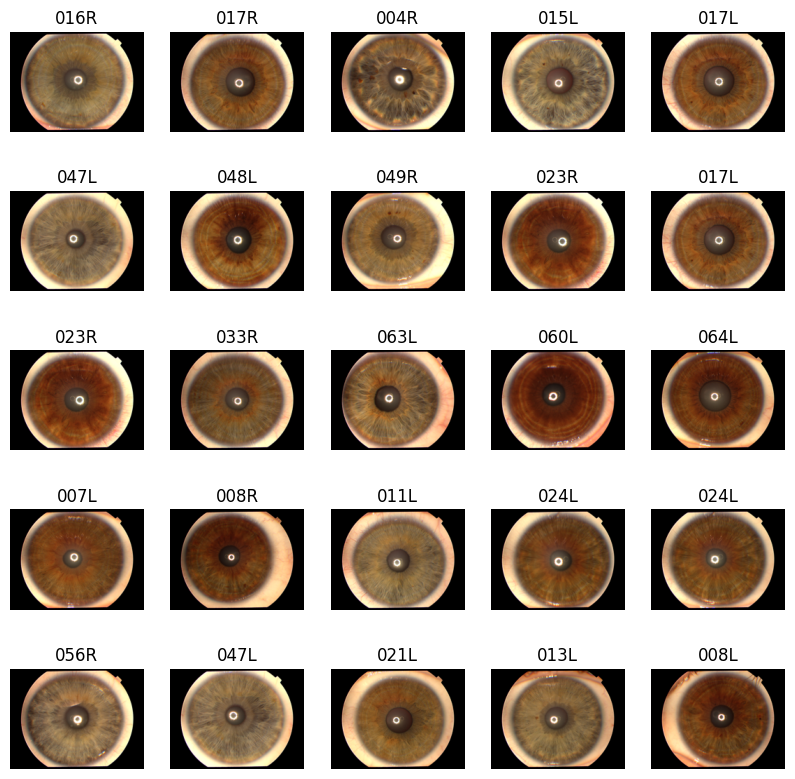

In [ ]:
# Примеры картинок с метками
fig = plt.figure(figsize=(10,10))

for i in range(25): 
    n = random.randint(0 , x_train.shape[0])   
    img = x_train[n]  
    label = Classes[np.argmax(y_train[n])] 
    ax = fig.add_subplot(5, 5, i+1)
    ax.set_title(label)
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [ ]:
VAL_SPLIT = 0.2
ROTATION_RANGE = 4                     
WIDTH_SHIFT_RANGE = 0.05                  
HEIGHT_SHIFT_RANGE = 0.05                  
ZOOM_RANGE = 0.05                 
BRIGHTNESS_RANGE = (0.7, 1.3)   

In [ ]:
datagen = ImageDataGenerator(
    rescale=1. / 255.,
    rotation_range=ROTATION_RANGE,
    width_shift_range=WIDTH_SHIFT_RANGE,
    height_shift_range=HEIGHT_SHIFT_RANGE,
    zoom_range=ZOOM_RANGE,
    brightness_range=BRIGHTNESS_RANGE 
)



In [ ]:
x_train_all, x_train_val, y_train_all, y_train_val = train_test_split(x_train, y_train, test_size = 0.2, shuffle = True)

In [ ]:
train_generator = datagen.flow(
    x_train_all, y_train_all,    
    batch_size=batch_size       
    )
val_generator = datagen.flow(
    x_train_val, y_train_val,                            
    batch_size=batch_size      
)

In [ ]:
print(f'       Обучающая выборка найдено файлов   {train_generator.n}')
print(f'     Проверочная выборка найдено файлов   {val_generator.n}')
print(f'  Количество батчей в обучающей выборке   {len(train_generator)}')
print(f'Количество батчей в проверочной выборке   {len(val_generator)}')
print(f'                           Размер батча   {train_generator.batch_size}')



       Обучающая выборка найдено файлов   10360
     Проверочная выборка найдено файлов   2590
  Количество батчей в обучающей выборке   162
Количество батчей в проверочной выборке   41
                           Размер батча   64


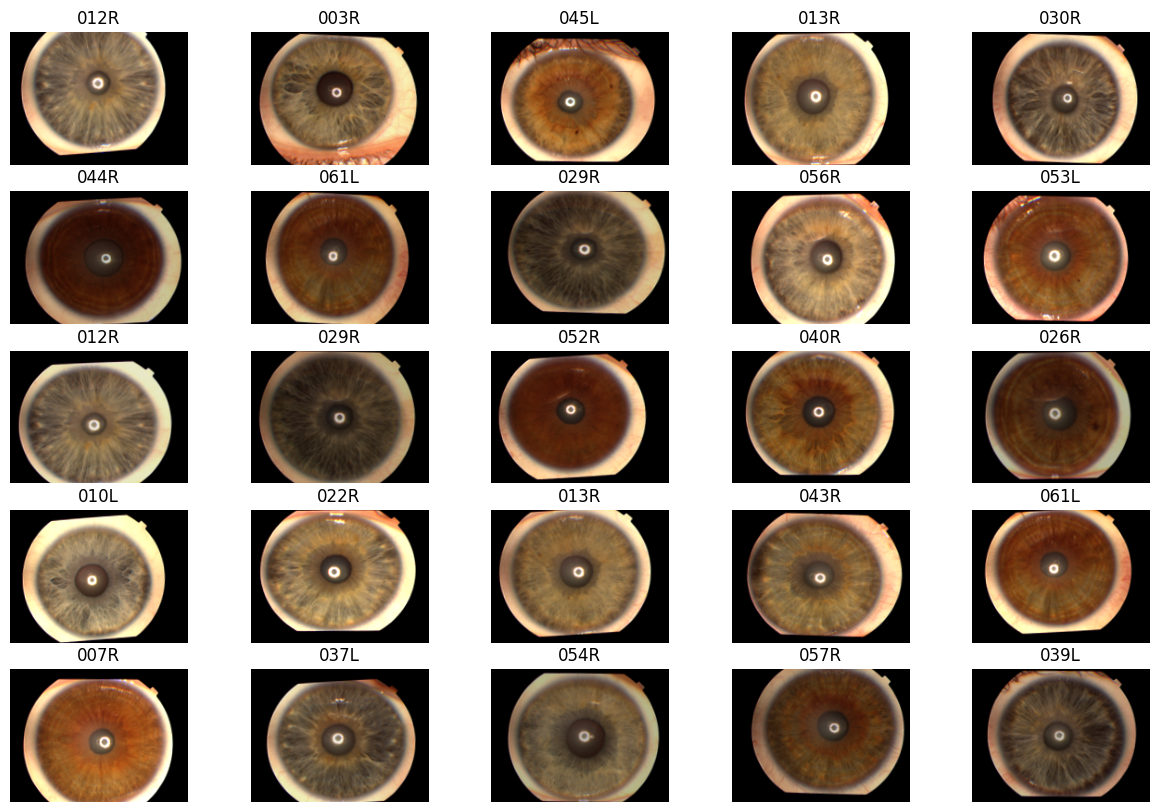

In [ ]:
# Примеры аугментированных картинок с метками

fig = plt.figure(figsize=(15,10))

for i in range(25): 
    n = random.randint(0, len(train_generator) - 1) 
    k = random.randint(0, train_generator.batch_size-1)  
    img = train_generator[n][0][k] 
    label = Classes[np.argmax(train_generator[n][1][k])] 
    ax = fig.add_subplot(5, 5, i+1)
    ax.set_title(label)
    ax.imshow(img)
    ax.axis('off')
plt.show()


# Обучение сети


In [ ]:
def on_epoch_end(epoch, logs):

  # Начиная с первой эпохи делаем дополнительную логику
  if epoch > 0:

    # Изменяем шаг обучения, если начинается “пила” на графике
    # или график выходит на плато.
    oldLr = round(model.optimizer.lr.numpy(), 4)
    cause = False
    # Что характеризует пилу? Идущее вниз значение val_accuracy. 
    if allValAccuracy[epoch - 1] > logs['val_accuracy']:
      cause = 'потенциальная пила'
    # А любое плато начинается с первого ровного участка.
    elif allValAccuracy[epoch - 1] == logs['val_accuracy']:
      cause = 'потенциальное плато' 
    if cause:
      # Выводим уведомление, что скорость обучения снижена.
      newLr = round(oldLr / 1.1, 4)
      model.optimizer.learning_rate.assign(newLr)
      print('Уменьшена скорость обучения. Было: {}, стало: {}. Причина: {}.'.format(oldLr, newLr, cause))
    else:
      print('Текущая скорость обучения: {}'.format(round(oldLr, 4)))

    # Сохраняем сеть с лучшей точностью в .h5 файл.
    maxValAccuracy = max(allValAccuracy)
    if maxValAccuracy < logs['val_accuracy']:
      model.save_weights('/content/drive/MyDrive/temp/best_weight.h5')
      print('\nВеса лучшей модели сохранены. Было val_accuracy {}, стало {}'.format(round(maxValAccuracy, 4), logs['val_accuracy']))
    else:
      print('Лучшая модель не изменилась. Mаксимальное val_accuracy: {}'.format(round(maxValAccuracy, 4)))

  # Для нулевой эпохи - просто сохраняем веса модели.
  else:
    model.save_weights('/content/drive/MyDrive/temp/best_weight.h5')
    print('Веса первой итерации сохранены при значении val_accuracy: {}'
    .format(logs['val_accuracy']))

  # Сохраняем текущие значения val_accuracy
  allValAccuracy.append(logs['val_accuracy'])

  print("___________________________________________________________________\n")


##################################################################
##################################################################
  
# Каллбэки
callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
del model

In [ ]:
#Сборка модели
image_shape = (IMG_HEIGHT, IMG_WIDTH, Channels)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=image_shape)
global_average_layer = GlobalAveragePooling2D()
prediction_layer1 = Dense(1024, activation='relu')
prediction_layer3 = Dense(2048, activation='relu')
prediction_layer2 = Dense(128, activation='softmax')

x = base_model.output
x = global_average_layer(x)
x = Dropout(0.2)(x)
x = prediction_layer1(x)
x = prediction_layer3(x)
outputs = prediction_layer2(x)
model = tf.keras.Model(inputs = base_model.inputs, outputs = outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 144, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 144, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 144, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 72, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 72, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 72, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 36, 48, 128)       0   

In [ ]:
learning_rate = 0.0001
epochs = 20
allValAccuracy = [0.85]  # требуется для callback 

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Epoch 1/20
162/162 [==============================] - ETA: 0s - loss: 2.9833 - accuracy: 0.2924Веса первой итерации сохранены при значении val_accuracy: 0.869111955165863
___________________________________________________________________

162/162 [==============================] - 83s 505ms/step - loss: 2.9833 - accuracy: 0.2924 - val_loss: 0.4026 - val_accuracy: 0.8691
Epoch 2/20
162/162 [==============================] - ETA: 0s - loss: 0.2450 - accuracy: 0.9254Текущая скорость обучения: 9.999999747378752e-05
Веса лучшей модели сохранены. Было val_accuracy 0.8691, стало 0.9988417029380798
___________________________________________________________________

162/162 [==============================] - 80s 497ms/step - loss: 0.2450 - accuracy: 0.9254 - val_loss: 0.0161 - val_accuracy: 0.9988
Epoch 3/20
162/162 [==============================] - ETA: 0s - loss: 0.0512 - accuracy: 0.9858Текущая скорость обучения: 9.999999747378752e-05
Лучшая модель не изменилась. Mаксимальное val_accuracy

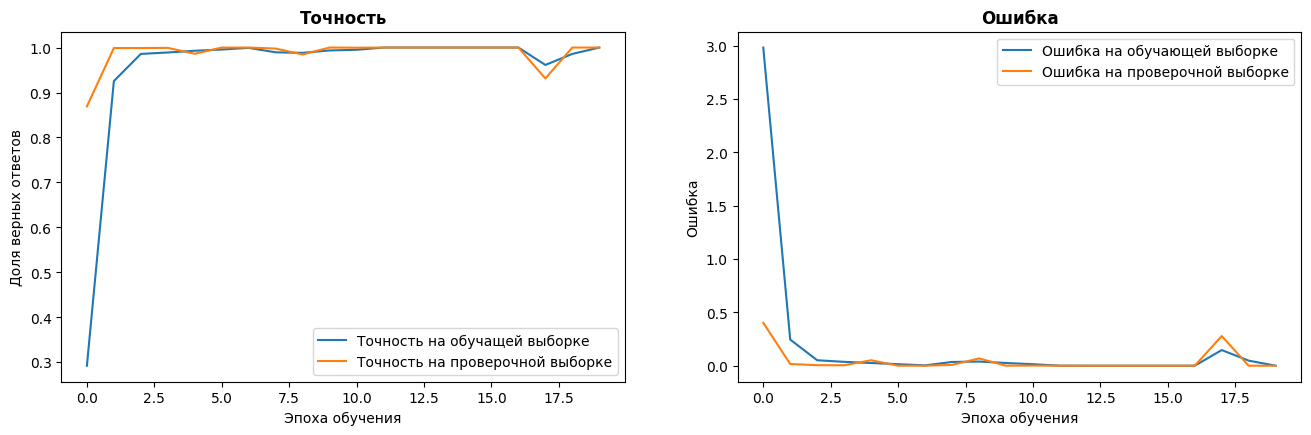

In [ ]:
History = model.fit(train_generator,                    
                    validation_data=val_generator,                    
                    epochs=epochs,
                    callbacks=[callback],
                    verbose= 1)

plot_result(History.history['accuracy'],
            History.history['val_accuracy'],
            History.history['loss'],
            History.history['val_loss'])

# Проверка на данных которые модель не видела

In [ ]:
model.save('/content/drive/MyDrive/Iris_ID/model.h5')

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Iris_ID/model.h5')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 144, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 144, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 144, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 72, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 72, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 72, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 36, 48, 128)       0   

In [ ]:
IMG_WIDTH = 192                          
IMG_HEIGHT = 144

In [ ]:
Classes = os.listdir(path_test)
Classes.sort()
print(Classes)
print(len(Classes))

['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R', '006L', '006R', '007L', '007R', '008L', '008R', '009L', '009R', '010L', '010R', '011L', '011R', '012L', '012R', '013L', '013R', '014L', '014R', '015L', '015R', '016L', '016R', '017L', '017R', '018L', '018R', '019L', '019R', '020L', '020R', '021L', '021R', '022L', '022R', '023L', '023R', '024L', '024R', '025L', '025R', '026L', '026R', '027L', '027R', '028L', '028R', '029L', '029R', '030L', '030R', '031L', '031R', '032L', '032R', '033L', '033R', '034L', '034R', '035L', '035R', '036L', '036R', '037L', '037R', '038L', '038R', '039L', '039R', '040L', '040R', '041L', '041R', '042L', '042R', '043L', '043R', '044L', '044R', '045L', '045R', '046L', '046R', '047L', '047R', '048L', '048R', '049L', '049R', '050L', '050R', '051L', '051R', '052L', '052R', '053L', '053R', '054L', '054R', '055L', '055R', '056L', '056R', '057L', '057R', '058L', '058R', '059L', '059R', '060L', '060R', '061L', '061R', '062L', '062R', '063L',

In [ ]:
# Формирование массивов x_test и y_test
x_test = []
y_test = []

num_class = 0
for cls in Classes:
    path_classes = os.path.join(path_test, cls)
    images = os.listdir(path_classes)
    for img in images:
        path_images = os.path.join(path_classes, img) 
        img = Image.open(path_images)
        img = img.resize((IMG_WIDTH, IMG_HEIGHT))  
        img_np = np.array(img) 
        x_test.append(img_np)
        y_test.append(num_class)
    num_class = num_class + 1

x_test = np.array(x_test)
x_test = x_test / 255
y_test = utils.to_categorical(y_test)
y_test = np.array(y_test)

print(f'Общий размер базы картинок: {len(x_test)} форма: {x_test.shape}')
print(f'Общий размер базы меток: {len(y_test)} форма: {y_test.shape}')  
print(f'Пример метки: {y_test[39]} ') 
print(f'Пример метки: {y_test[40]} ') 
print(f'Пример метки: {y_test[100]} ')

Общий размер базы картинок: 125 форма: (125, 144, 192, 3)
Общий размер базы меток: 125 форма: (125, 128)
Пример метки: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] 
Пример метки: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] 
Пример метки: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

1/1 [==============================] - 0s 20ms/step


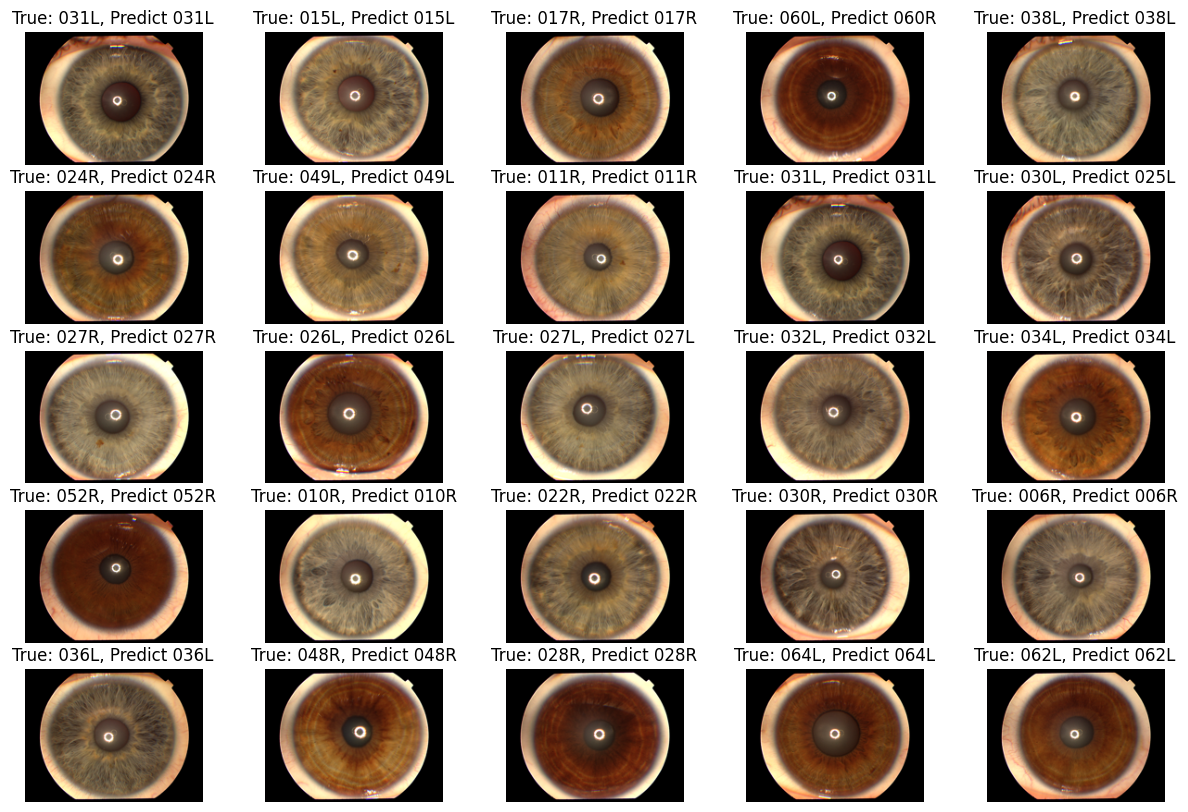

In [ ]:
fig = plt.figure(figsize=(15,10))

for i in range(25): 
    n = random.randint(0, len(x_test) - 1)     
    img = x_test[n]    
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(img)
    ax.axis('off')
    img_np = np.array([x_test[n]])
    prediction = model.predict(img_np) 
    ax.set_title(f'True: {Classes[np.argmax(y_test[n])]}, Predict {Classes[np.argmax(prediction)]}') 
    
    
plt.show()   


In [ ]:
scores = model.evaluate(x_test, y_test)

4/4 [==============================] - 1s 190ms/step - loss: 0.5727 - accuracy: 0.9040


In [ ]:
%load_ext tensorboard

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Lambda
from keras.layers import Input
from keras import backend as K

# image_shape = (IMG_HEIGHT, IMG_WIDTH, 1)
image_shape = (144, 192, 3)
# Преобразование входного изображения к формату (высота, ширина, 3)
model_input = Input(shape=image_shape)
# x = Lambda(lambda image: K.repeat_elements(image, 3, axis=3))(model_input)

# Использование ResNet50 с измененным входным изображением
# base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=x)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=image_shape)
global_average_layer = GlobalAveragePooling2D()
prediction_layer1 = Dense(512, activation='relu')
prediction_layer2 = Dense(1024, activation='relu')
prediction_layer3 = Dense(128, activation='softmax')

x = base_model.output
x = global_average_layer(x)
x = Dropout(0.2)(x)
x = prediction_layer1(x)
# x = Dropout(0.2)(x)
x = prediction_layer2(x)
# x = Dropout(0.2)(x)
outputs = prediction_layer3(x)

model_ResNet = tf.keras.Model(inputs=base_model.input, outputs=outputs)

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
del history

In [ ]:
del model_ResNet

In [ ]:
epochs = 10

Epoch 1/10
162/162 [==============================] - 89s 511ms/step - loss: 3.7609 - accuracy: 0.4019 - val_loss: 4.9227 - val_accuracy: 0.0073
Epoch 2/10
162/162 [==============================] - 81s 497ms/step - loss: 1.2901 - accuracy: 0.9426 - val_loss: 4.9457 - val_accuracy: 0.0054
Epoch 3/10
162/162 [==============================] - 80s 495ms/step - loss: 0.1624 - accuracy: 0.9997 - val_loss: 4.9641 - val_accuracy: 0.0112
Epoch 4/10
162/162 [==============================] - 81s 498ms/step - loss: 0.0504 - accuracy: 1.0000 - val_loss: 4.8720 - val_accuracy: 0.0220
Epoch 5/10
162/162 [==============================] - 80s 495ms/step - loss: 0.0266 - accuracy: 1.0000 - val_loss: 3.8890 - val_accuracy: 0.1977
Epoch 6/10
162/162 [==============================] - 80s 496ms/step - loss: 0.0171 - accuracy: 1.0000 - val_loss: 0.9273 - val_accuracy: 0.8992
Epoch 7/10
162/162 [==============================] - 80s 495ms/step - loss: 0.0113 - accuracy: 1.0000 - val_loss: 0.0136 - val_ac

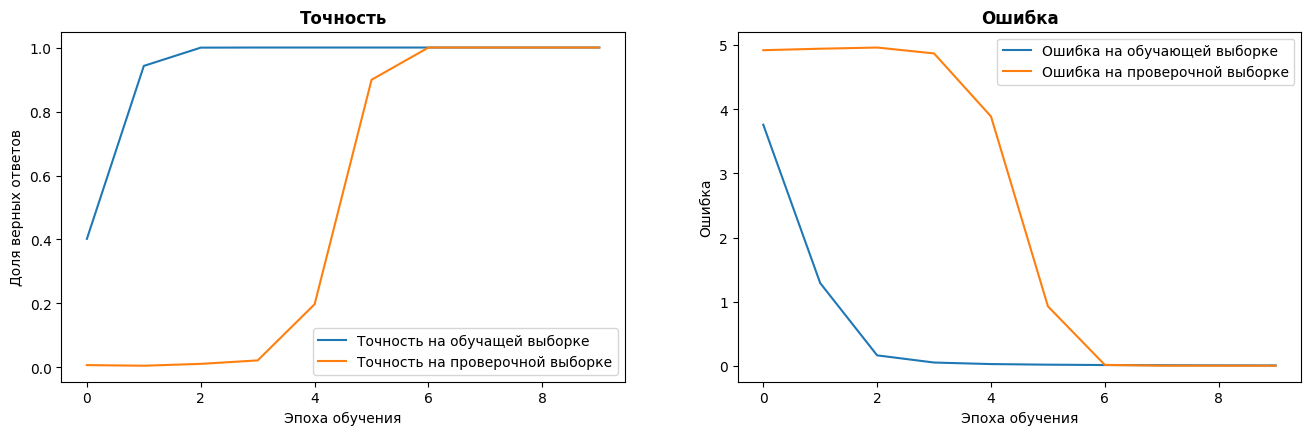

In [ ]:
model_ResNet.compile(optimizer=Adam(learning_rate=0.00001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
              
History = model_ResNet.fit(train_generator,                    
                    validation_data=val_generator,                    
                    epochs=epochs,
                    verbose= 1)

plot_result(History.history['accuracy'],
            History.history['val_accuracy'],
            History.history['loss'],
            History.history['val_loss'])

In [ ]:
ls -l logs/ 


ls: cannot access 'logs/': No such file or directory


In [ ]:
%tensorboard --logdir '/tmp/mylogs/iris'

In [ ]:
!rm -rf logs/plots

In [ ]:
# Получение случайных индексов изображений
random_indices = np.random.choice(len(test_generator), 5)

# Получение изображений и меток по случайным индексам
images = x_valid[random_indices]
true_labels = y_valid[random_indices]

# Предсказание классов для изображений
predicted_labels = model.predict(images)

# Вывод изображений и меток в одну строку
fig, axs = plt.subplots(1, 5, figsize=(17, 3))
for i in range(5):
    # Отображение изображения в серых тонах
    axs[i].imshow(images[i].reshape((IMG_HEIGHT, IMG_WIDTH)), cmap='gray')
    # Отображение меток
    axs[i].set_title(f"True: {np.argmax(true_labels[i])}, \nPredict: {np.argmax(predicted_labels[i])}")
    axs[i].axis('off')
plt.show()

NameError: ignored

1/1 [==============================] - 0s 23ms/step


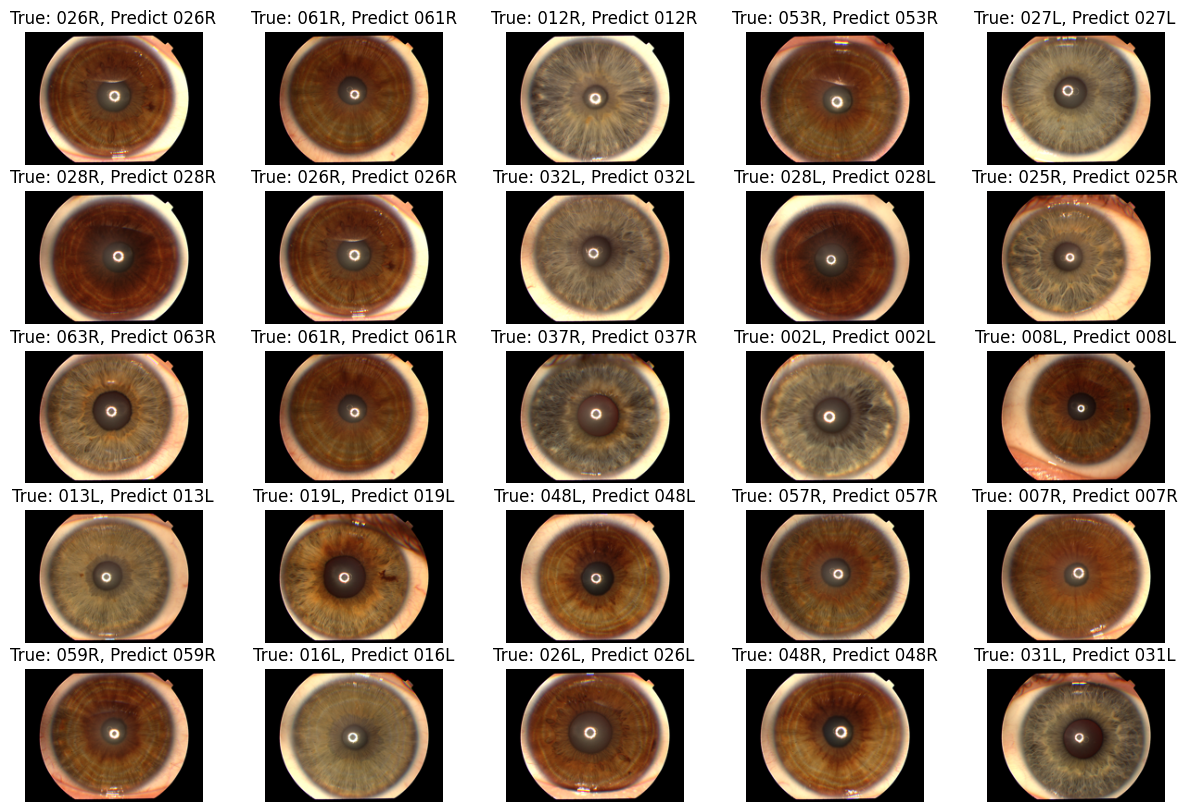

In [ ]:
fig = plt.figure(figsize=(15,10))

for i in range(25): 
    n = random.randint(0, len(x_test) - 1)     
    img = x_test[n]    
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(img)
    ax.axis('off')
    img_np = np.array([x_test[n]])
    prediction = model_ResNet.predict(img_np) 
    ax.set_title(f'True: {Classes[np.argmax(y_test[n])]}, Predict {Classes[np.argmax(prediction)]}') 
    
    
plt.show()   


In [ ]:
# # Install and load TensorBoard extension
# !pip install -q tb-nightly
# %load_ext tensorboard

# # Start TensorBoard
# from tensorflow.keras.callbacks import TensorBoard
# log_dir = "/content/drive/MyDrive/IrisID/logs/"  # Replace with your actual logs directory
# tensorboard_callback = TensorBoard(log_dir=log_dir)
# %tensorboard --logdir=log_dir  # Replace with your actual logs directory

# Autokeras

In [ ]:
# устанавливаем Autokeras
!pip install autokeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 97.3 MB/s eta 0:00:00
ERROR: Operation cancelled by user


In [ ]:
del best_model, clf

NameError: ignored

In [ ]:
import autokeras as ak

# Инициализация классификатора AutoKeras
clf = ak.ImageClassifier(
    max_trials=5,
    objective='val_accuracy',
    tuner='greedy',
    # directory='pavement_crack',
    overwrite=True)

clf.fit(x_train_all, y_train_all, epochs=8, validation_data=(x_train_val, y_train_val))


In [ ]:
best_model = clf.export_model()
# Получите архитектуру модели в виде JSON строки
model_json = best_model.to_json()

print("Model architecture:")
print(model_json)

# Оценка модели
score2 = best_model.evaluate(x_test, y_test)
print("Test accuracy:", score2[1])

In [ ]:
best_model.summary()

In [ ]:
# для более детального изучение параметров модели,можно итерировать по слоям модели:
print("\nLayer details:")
for layer in best_model.layers:
    print(f"Layer name: {layer.name}")
    print(f"Layer type: {type(layer)}")
    config = layer.get_config()
    print("Layer configuration:")
    for key, value in config.items():
        print(f"  {key}: {value}")

optimizer = best_model.optimizer
learning_rate = optimizer.lr
print(f"\nLearning rate: {learning_rate}")

In [ ]:
fig = plt.figure(figsize=(15,10))

for i in range(5): 
    n = random.randint(0, len(x_test) - 1)     
    img = x_test[n]    
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(img)
    ax.axis('off')
    img_np = np.array([x_test[n]])
    prediction = best_model.predict(img_np) 
    ax.set_title(f'True: {Classes[np.argmax(y_test[n])]}, Predict {Classes[np.argmax(prediction)]}') 
    
    
plt.show()   


# TODO Проверка работы нейросети

In [ ]:

# Шаг 4: Проверка работы нейросети на новых данных

# Загрузка изображения незарегистрированного пациента
test_image_path = 'path/to/test/image.jpg'  # Путь к изображению незарегистрированного пациента
test_image = tf.keras.preprocessing.image.load_img(test_image_path, target_size=image_size)
test_image = tf.keras.preprocessing.image.img_to_array(test_image)
test_image = test_image / 255.0
test_image = tf.expand_dims(test_image, axis=0)

# Предсказание класса для изображения незарегистрированного пациента
prediction = model.predict(test_image)
predicted_class = tf.argmax(prediction, axis=1).numpy()[0]
probability = prediction[0][predicted_class]

# Установка пороговых значений
threshold_prediction = 0.97
threshold_far = 0.02
threshold_frr = 0.03

# Проверка результатов
if probability < threshold_prediction:
    print("Недопуск: Пациент отсутствует в базе")
else:
    if probability > threshold_far:
        print("Ложный допуск: Пациент не зарегистрирован, но система его идентифицировала")
    elif probability < threshold_frr:
        print("Ложный недопуск: Пациент зарегистрирован, но система не идентифицировала его")
    else:
        print("Идентификация пациента успешна")

In [ ]:
# Шаг 5: Дообучение нейросети при добавлении новых пациентов

# Дополнительные данные для новых пациентов
new_patient_data_dir = 'path/to/new/patient/data'  # Путь к папке с данными новых пациентов

# Добавление новых данных в обучающий набор
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Дообучение модели на новых данных
model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

# Шаг 6: Проверка работы нейросети снова после дообучения

# Загрузка изображения незарегистрированного пациента после дообучения
test_image_path = 'path/to/test/image.jpg'  # Путь к изображению незарегистрированного пациента
test_image = tf.keras.preprocessing.image.load_img(test_image_path, target_size=image_size)
test_image = tf.keras.preprocessing.image.img_to_array(test_image)
test_image = test_image / 255.0
test_image = tf.expand_dims(test_image, axis=0)

# Предсказание класса для изображения незарегистрированного пациента после дообучения
prediction = model.predict(test_image)
predicted_class = tf.argmax(prediction, axis=1).numpy()[0]
probability = prediction[0][predicted_class]

# Проверка результатов после дообучения
if probability < threshold_prediction:
    print("Недопуск: Пациент отсутствует в базе")

# Шаг 7: Идентификация пациента

# Предсказание класса для изображения пациента
patient_image_path = 'path/to/patient/image.jpg'  # Путь к изображению пациента
patient_image = tf.keras.preprocessing.image.load_img(patient_image_path, target_size=image_size)
patient_image = tf.keras.preprocessing.image.img_to_array(patient_image)
patient_image = patient_image / 255.0
patient_image = tf.expand_dims(patient_image, axis=0)

# Предсказание класса для изображения пациента
prediction = model.predict(patient_image)
predicted_class = tf.argmax(prediction, axis=1).numpy()[0]
probability = prediction[0][predicted_class]

# Проверка результатов идентификации пациента
if probability >= threshold_prediction:
    print("Пациент идентифицирован: Класс", predicted_class)
else:
    print("Недопуск: Пациент отсутствует в базе")